In [1]:
!ls ../resources/context_filter

nodecoder_test_0  nodecoder_train_0  nodecoder_val_0  test_0  train_0  valid_0


In [6]:
!ln -s ../context_nmt ./

In [30]:
train_path = '/home/litong/context_translation/resources/train_77b9dbd0538187438b8dd13a8f6b935c.pkl'
valid_path = '/home/litong/context_translation/resources/valid_0a06896723176aff827aac15a2e1ac94.pkl'
test_path = '/home/litong/context_translation/resources/test_312c4d4a71cc6fc659e7a08be8346726.pkl'

In [94]:
enja_nodecoder_filtered_context = '/home/litong/context_translation/resources/context_filter/outdated/jiji_context_filter_nodecoder_en_ja_0'
jaen_nodecoder_filtered_context = '/home/litong/context_translation/resources/context_filter/outdated/jiji_context_filter_nodecoder_ja_en_0'

In [72]:
import random
import pickle
from context_nmt.data.dataset_readers.context_translation_dataset_reader import read_context_index_file
import pandas as pd
import itertools

In [2]:
enja_filtered_context = '/home/litong/context_translation/resources/context_filter/jiji_context_filter_translated_limited_en_ja_0'
jaen_filtered_context = '/home/litong/context_translation/resources/context_filter/jiji_context_filter_translated_limited_ja_en_0'

In [31]:
with open(test_path, 'rb') as source:
    test_data = pickle.load(source)

In [32]:
test_data

{'conver_test_0': defaultdict(list,
             {'en': ['Can I ask you for a favor?',
               'Sure.',
               "I'm going to Brazil next week for a business trip.",
               "But I'm actually not familiar with Brazil.",
               'Do you think you can gather some materials on Brazil?',
               'What kind of material are you looking for?',
               'Well the business partner in Brazil is in the forest industry so information on that would be great.',
               'Okay, so the forest industry in Brazil.',
               'Do you want information like number of sawmills, and harvest data?',
               'Can you also find out what their logging regulations are as well?',
               'I think so.',
               "What's the purpose of your meeting again?",
               "I'm going to see if we should invest in their sawmill.",
               'They produce lumber for the Chinese and European market.',
               'I guess I should also look

In [224]:
oracle_enja = pd.read_csv('../resources/nmt_output/en_ja/oracle_table_test.tsv', delimiter='\t')
oracle_jaen = pd.read_csv('../resources/nmt_output/ja_en/oracle_table_test.tsv', delimiter='\t')

In [226]:
def readable_model_name(model):
    if 'bias' not in model:
        return -1
    else:
        return int(model.split("_bias_")[-1][0])
oracle_enja['model'] = oracle_enja['model'].apply(readable_model_name)
oracle_jaen['model'] = oracle_jaen['model'].apply(readable_model_name)

In [227]:
def add_context_sent_id(df, pairs):
    indexes = []
    lengths = [len(doc) for doc in pairs.values()]
    start = 0
    for length in lengths:
        for index, row in df.iloc[start:start + length].iterrows():
            bias = row['model']
            if bias == -1 or index < bias:
                indexes.append(-1)
            else:
                indexes.append(bias)
        start = length
    df['context_sent_id'] = indexes

In [228]:
add_context_sent_id(oracle_enja, enja_test_pairs)
add_context_sent_id(oracle_jaen, jaen_test_pairs)

In [229]:
def judge(oracle, pairs):
    answers = list(oracle['context_sent_id'])
    guesses = list(itertools.chain.from_iterable([[index for index, _ in doc.values() ] for doc in pairs.values()]))
    return sum([answer == guess for answer, guess in zip(answers, guesses)])

In [230]:
judge(oracle_enja, enja_test_pairs)

80

In [231]:
judge(oracle_jaen, jaen_test_pairs)

98

In [232]:
judge(oracle_enja, enja_nodecoder_test_pairs)

88

In [233]:
judge(oracle_jaen, jaen_nodecoder_test_pairs)

144

In [109]:
sum(map(sum, [[enja_test_pairs[doc_id][sent_id][0] == enja_nodecoder_test_pairs[doc_id][sent_id][0] for sent_id in doc] for doc_id, doc in enja_test_pairs.items()]))

1256

In [111]:
sum(map(sum, [[jaen_test_pairs[doc_id][sent_id][0] == jaen_nodecoder_test_pairs[doc_id][sent_id][0] for sent_id in doc] for doc_id, doc in jaen_test_pairs.items()]))

959

In [58]:
dict(oracle_enja.groupby('model').count()['reference'])

{-1: 730, 1: 385, 2: 283, 3: 187, 4: 296, 5: 239}

In [57]:
dict(oracle_jaen.groupby('model').count()['reference'])

{-1: 184, 1: 372, 2: 225, 3: 210, 4: 290, 5: 839}

In [55]:
enja_test_counter

{-1: 287, 1: 861, 2: 346, 3: 232, 4: 194, 5: 200}

In [56]:
jaen_test_counter

{-1: 336, 1: 659, 2: 348, 3: 283, 4: 258, 5: 236}

# Plot some graphs

In [3]:
enja_context_pairs = read_context_index_file(enja_filtered_context)
jaen_context_pairs = read_context_index_file(jaen_filtered_context)

In [95]:
enja_nodecoder_context_pairs = read_context_index_file(enja_nodecoder_filtered_context)
jaen_nodecoder_context_pairs = read_context_index_file(jaen_nodecoder_filtered_context)

In [5]:
nodecoder_context_pairs = read_context_index_file(nodecoder_filtered_context)

In [186]:
def get_three_set(pairs, keys=None):
    test, valid, train = {}, {}, {}
    for doc_id, data in pairs.items():
        if 'conver_test' in doc_id:
            test[doc_id] = data
        elif 'conver_valid' in doc_id:
            valid[doc_id] = data
        else:
            if keys:
                if doc_id in keys:
                    train[doc_id] = {sent_id: context_data for sent_id, context_data in data.items() if sent_id in keys[doc_id] }
            else:
                train[doc_id] = data
    return test, valid, train

In [184]:
enja_test, enja_valid, enja_train = get_three_set(enja_context_pairs)
jaen_test, jaen_valid, jaen_train = get_three_set(jaen_context_pairs)

In [187]:
enja_nd_test, enja_nd_valid, enja_nd_train = get_three_set(enja_nodecoder_context_pairs, enja_train)
jaen_nd_test, jaen_nd_valid, jaen_nd_train = get_three_set(jaen_nodecoder_context_pairs, jaen_train)

In [189]:
enja_test_counter, enja_valid_counter, enja_train_counter = [get_counter(pairs) for pairs in (enja_test, enja_valid, enja_train)]
jaen_test_counter, jaen_valid_counter, jaen_train_counter = [get_counter(pairs) for pairs in (jaen_test, jaen_valid, jaen_train)]
enja_nd_test_counter, enja_nd_valid_counter, enja_nd_train_counter = [get_counter(pairs) for pairs in (enja_nd_test, enja_nd_valid, enja_nd_train)]
jaen_nd_test_counter, jaen_nd_valid_counter, jaen_nd_train_counter = [get_counter(pairs) for pairs in (jaen_nd_test, jaen_nd_valid, jaen_nd_train)]

In [176]:
def get_dataframe(test, valid=None, train=None):
    if train:
        result = {split: data for split, data in zip(("train", "valid", "test"), (train, valid, test))}
    else:
        result = {split: data for split, data in zip(("valid", "test"), (valid, test))}
    return pd.DataFrame(result)

In [177]:
enja_table = get_dataframe(enja_test_counter, enja_valid_counter, enja_train_counter)
jaen_table = get_dataframe(jaen_test_counter, jaen_valid_counter, jaen_train_counter)
enja_nd_table = get_dataframe(enja_nd_test_counter, enja_nd_valid_counter, enja_nd_train_counter)
jaen_nd_table = get_dataframe(jaen_nd_test_counter, jaen_nd_valid_counter, jaen_nd_train_counter)

In [158]:
enja_table = get_dataframe(enja_test_counter, enja_valid_counter)
jaen_table = get_dataframe(jaen_test_counter, jaen_valid_counter)
enja_nd_table = get_dataframe(enja_nd_test_counter, enja_nd_valid_counter)
jaen_nd_table = get_dataframe(jaen_nd_test_counter, jaen_nd_valid_counter)

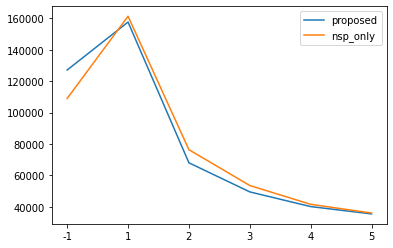

In [203]:
pd.DataFrame({"proposed": enja_train_counter, 'nsp_only': enja_nd_train_counter}).plot()

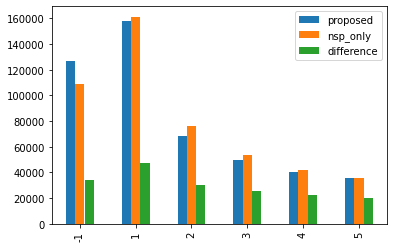

In [209]:
pd.DataFrame({"proposed": enja_train_counter, 'nsp_only': enja_nd_train_counter, 'difference': get_differency(enja_train, enja_nd_train)}).plot(kind='bar')

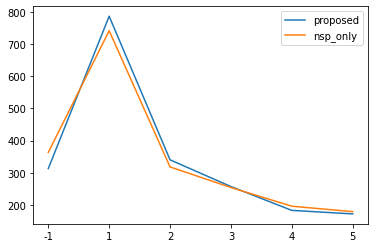

In [199]:
pd.DataFrame({"proposed": enja_valid_counter, 'nsp_only': enja_nd_valid_counter}).plot()

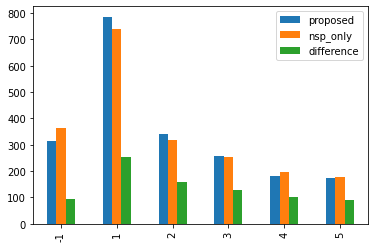

In [210]:
pd.DataFrame({"proposed": enja_valid_counter, 'nsp_only': enja_nd_valid_counter, 'difference': get_differency(enja_valid, enja_nd_valid)}).plot(kind='bar')

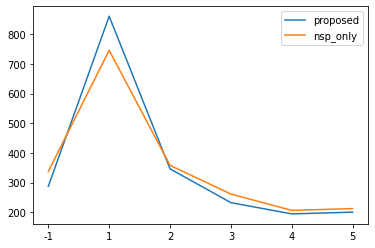

In [216]:
ax = pd.DataFrame({"proposed": enja_test_counter, 'nsp_only': enja_nd_test_counter}).plot()
ax.figure.savefig("/home/litong/context_translation/resources/nmt_output/enja_test_distribution.png")

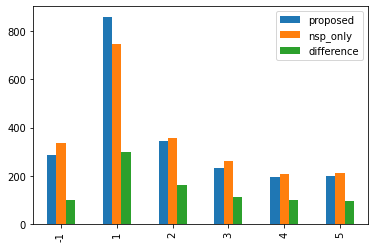

In [217]:
ax = pd.DataFrame({"proposed": enja_test_counter, 'nsp_only': enja_nd_test_counter, 'difference': get_differency(enja_test, enja_nd_test)}).plot(kind='bar')
ax = ax.figure.savefig("/home/litong/context_translation/resources/nmt_output/enja_test_difference.png")

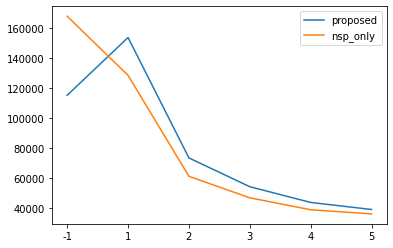

In [195]:
pd.DataFrame({"proposed": jaen_train_counter, 'nsp_only': jaen_nd_train_counter}).plot()

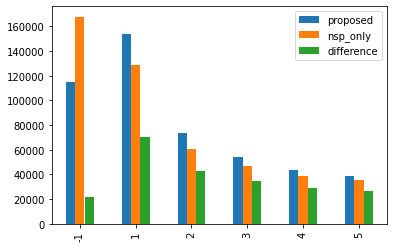

In [212]:
pd.DataFrame({"proposed": jaen_train_counter, 'nsp_only': jaen_nd_train_counter, 'difference': get_differency(jaen_train, jaen_nd_train)}).plot(kind='bar')

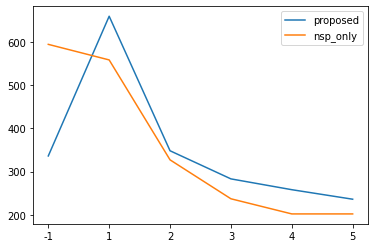

In [218]:
ax = pd.DataFrame({"proposed": jaen_test_counter, 'nsp_only': jaen_nd_test_counter}).plot()
ax = ax.figure.savefig("/home/litong/context_translation/resources/nmt_output/jaen_test_distribution.png")

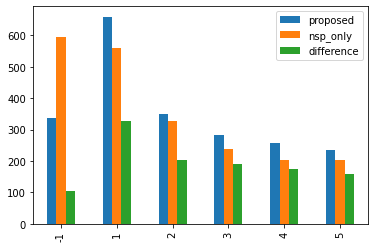

In [219]:
ax = pd.DataFrame({"proposed": jaen_test_counter, 'nsp_only': jaen_nd_test_counter, 'difference': get_differency(jaen_test, jaen_nd_test)}).plot(kind='bar')
ax = ax.figure.savefig("/home/litong/context_translation/resources/nmt_output/jaen_test_difference.png")

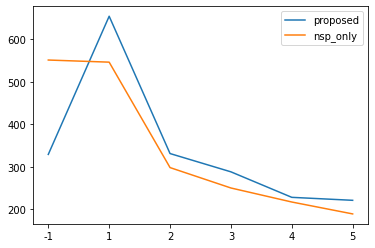

In [197]:
pd.DataFrame({"proposed": jaen_valid_counter, 'nsp_only': jaen_nd_valid_counter}).plot()

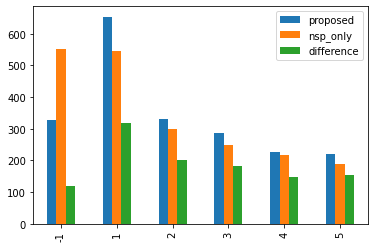

In [214]:
pd.DataFrame({"proposed": jaen_valid_counter, 'nsp_only': jaen_nd_valid_counter, 'difference': get_differency(jaen_valid, jaen_nd_valid)}).plot(kind='bar')

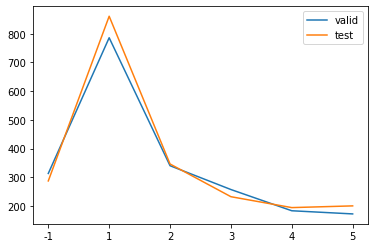

In [159]:
enja_table.plot()

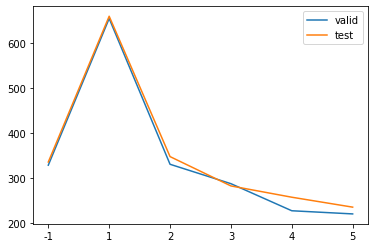

In [160]:
jaen_table.plot()

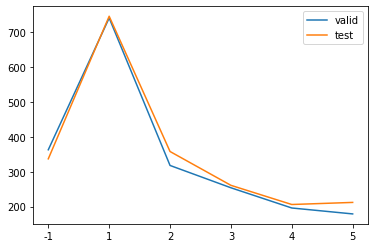

In [161]:
enja_nd_table.plot()

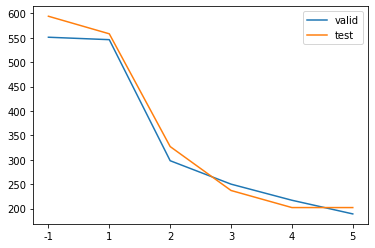

In [162]:
jaen_nd_table.plot()

In [154]:
from collections import Counter
import matplotlib.pyplot as plt

def get_counter(pairs):
    counter = Counter()
    for _, doc in pairs.items():
        for sent_id, (cs_id, score) in doc.items():
            if cs_id == -1:
                counter[-1] += 1
            else:
                counter[sent_id - cs_id] += 1
    counter = {str(key): value for key, value in (sorted(list(counter.items()), key=lambda x : x[0]))}
    return counter

In [5]:
enja_counter = get_counter(enja_context_pairs)
jaen_counter = get_counter(jaen_context_pairs)

In [25]:
enja_test_counter = get_counter(enja_test_pairs)
jaen_test_counter = get_counter(jaen_test_pairs)

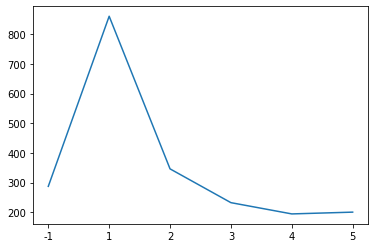

In [53]:
enja_test_counter = plot_from_counter(enja_test_counter)

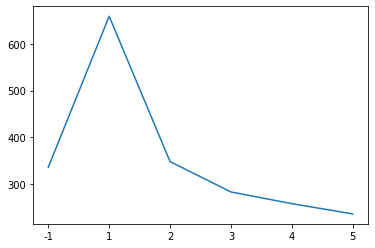

In [54]:
jaen_test_counter = plot_from_counter(jaen_test_counter)

In [8]:
sum([len(doc) for doc in enja_context_pairs.values()])
sum([len(doc) for doc in jaen_context_pairs.values()])

482310

In [121]:
def plot_from_counter(counter):
    data = sorted([(key, value) for key, value in counter.items()], key=lambda x : x[0])
    x = [str(point[0]) for point in data]
    y = [point[1] for point in data]
    return plt.plot(x, y)
    # return {key: value for key, value in data}

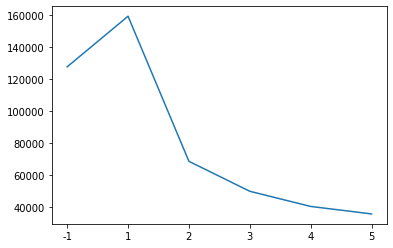

In [20]:
plot_from_counter(enja_counter)

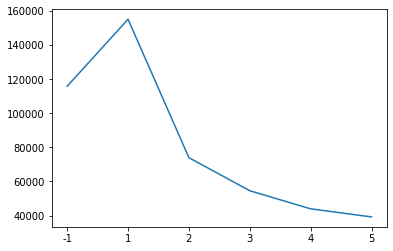

In [21]:
plot_from_counter(jaen_counter)

In [206]:
def get_differency(context_pairs, nodecoder_context_pairs):
    differency = Counter()
    for d_id, doc in context_pairs.items():
        for s_id, (cs_id, score) in doc.items():
            if cs_id == -1:
                key = "-1"
            else:
                key = str(s_id - cs_id)
            if cs_id != nodecoder_context_pairs[d_id][s_id][0]:
                differency[key] += 1
    counter = {str(key): value for key, value in (sorted(list(differency.items()), key=lambda x : x[0]))}
    return counter

In [60]:
differency

Counter({'1': 83670,
         '2': 41887,
         '5': 20362,
         '4': 23854,
         '-1': 37202,
         '3': 31129})

In [56]:
counter, nodecoder_counter = [get_counter(pairs) for pairs in (context_pairs, nodecoder_context_pairs)]

In [17]:
sum(counter.values()) == sum(nodecoder_counter.values())

True

In [68]:
counter = {str(key): value for key, value in counter.items()}
nodecoder_counter = {str(key): value for key, value in nodecoder_counter.items()}

In [62]:
import pandas as pd

In [69]:
counter_frame = pd.DataFrame([{'position': key, 'proposed': counter[key], 'nodeoder': nodecoder_counter[key], 'different': differency[key]} for key in counter])

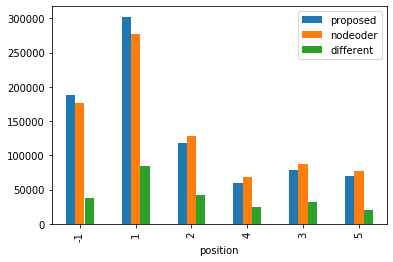

In [70]:
counter_frame.plot(x='position', kind='bar')

From the results generated from the first iteration of BERT fine-tuning, we can find that proposed method is picking out more one sentence before and no context than the baseline nomarl BERT fine-tuning. On the other, they have similiar distribution on the picked previous sentnces other than the one before.

In [9]:
with open(test_path, 'rb') as source:
    test_data = pickle.load(source)
with open(valid_path, 'rb') as source:
    valid_data = pickle.load(source)

In [24]:
def get_pairs(data, context_pairs, lang="en"):
    def get_pair(doc_id, sent_id):
        context_index = context_pairs[doc_id][sent_id][0]
        if context_index == -1:
            context = ""
        else:
            context = data[doc_id][lang][context_index]
        sent = data[doc_id][lang][sent_id]
        return (context_index, sent_id, context, sent)
    pairs = []
    for doc_id, doc in data.items():
        for sent_id, score in doc["pairs"]:
            pairs.append(get_pair(doc_id, sent_id))
    return pairs

# No Decoder

In [31]:
nd_valid_cp = read_context_index_file('../resources/context_filter/nodecoder_val_0')
nd_valid_pairs = get_pairs(valid_data, nd_valid_cp)
nd_test_cp = read_context_index_file('../resources/context_filter/nodecoder_test_0')
nd_test_pairs = get_pairs(test_data, nd_test_cp)

# With Decoder

In [33]:
valid_cp = read_context_index_file('../resources/context_filter/valid_0')
valid_pairs = get_pairs(valid_data, valid_cp)
test_cp = read_context_index_file('../resources/context_filter/test_0')
test_pairs = get_pairs(test_data, test_cp)

In [34]:
val_indexs = [random.randint(0, len(nd_valid_pairs)) for _ in range(10)]
test_indexs = [random.randint(0, len(nd_test_pairs)) for _ in range(10)]

In [35]:
print(val_indexs)
print(test_indexs)

[104, 898, 1656, 1716, 653, 111, 1383, 1266, 42, 798]
[1777, 1524, 1308, 1514, 1543, 1731, 1642, 1238, 230, 460]


In [40]:
print(sum([valid[0] != nd_valid[0] for valid, nd_valid in zip(valid_pairs, nd_valid_pairs)]))
print(len(valid_pairs))

979
2051


In [41]:
print(sum([test[0] != nd_test[0] for test, nd_test in zip(test_pairs, nd_test_pairs)]))
print(len(test_pairs))

1019
2120


In [42]:
import sacrebleu

In [56]:
help(sacrebleu.corpus_bleu)

Help on function corpus_bleu in module sacrebleu:

corpus_bleu(sys_stream: Union[str, Iterable[str]], ref_streams: Union[str, List[Iterable[str]]], smooth_method='exp', smooth_value=0.0, force=False, lowercase=False, tokenize='13a', use_effective_order=False) -> sacrebleu.BLEU
    Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_value: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want

